# 06 Klassifitseerimismudelid

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
data = pd.read_excel('toofailid/DATA_TEKSTIKOGU_puhastatud.xlsx', engine='openpyxl')
print(data.shape)

(636, 55)


In [65]:
sagedused = data['Lahendi liik'].value_counts()

In [66]:
sagedused

õigeksmõistev    350
tauniv           286
Name: Lahendi liik, dtype: int64

In [67]:
# Andmestiku segamine
#from sklearn.utils import shuffle
#data = shuffle(data)
#data = data.reset_index(drop=True)

In [68]:
# Ebavajaliku info  (aeg, pealkiri) eemaldamine
#data.drop(["date"],axis=1,inplace=True)
#data.drop(["title"],axis=1,inplace=True)
#data.drop(["subject"],axis=1,inplace=True)
#data.drop(["link"],axis=1,inplace=True)

In [69]:
#tekst_puhas = data['text_puhas'].to_list()
#tekst_tokenize = data['text_token'].to_list()
#tekst_lemmatize = data['text_lemmatize'].to_list()
#label = data['Lahendi liik'].to_list()

Stoppsõnadena on kasutusel sidesõnad ja sidesõnad koos asesõnadega.

In [70]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']

# Veamaatriks, segadusmaatriks (confusion matrix)

Veamaatriks väljendab saadud mudeli headust. Maatriksi peadiagonaalil asetsevad kõik klassifikaatori pool õigesti ennustatud väärtused: õiged positiivsed, õiged negatiivsed. Kõik, mis jääb peadiagonaalilt välja, on väärad: vale positiivsed, vale negatiivsed. Mida rohkem õigeid negatiivseid ja õigeid positiivseid tulemusi, seda parem mudel. 

                  Väär  | õige negatiivne    | vale positiivne
                  _______________________________________________          Tegelik märgend
                  
                  Tõene | vale negatiivne    | õige positiivne
                  _______________________________________________
                              Väär                Tõene
                  
                                Ennustatud märgend
   
                    

In [71]:
# Veamaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Veamaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud veamaatriks")
    else:
        print('Normaliseerimata veamaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

# Sõnade vektoresitused ja dokument-sõna maatriks

Tekstide automaatsel klassifitseerimisel või klasterdamisel viiakse analüüsitava korpuse dokumendid vektorkujule ehk:

luuakse iga korpuse sõna kohta vektor, mille iga positsioon kirjeldab sõna esinemist ühes korpuse dokumendis;
kõigi sõnade vektoritest pannakse kokku maatriks, mille järgi saab leida nii üksiksõnade esinemismustreid kui ka dokumenti iseloomustava sõnavaramustri.
Sarnasuste leidmisel tuginevadki statistilised meetodid maatriksile ning tekstide omadused, mis maatriksis ei kajastu (nt sõnade omavaheline järjekord, lausestus, süntaks vms) tulemust otseselt ka ei mõjuta. 

Klass CountVectorizer võimaldab luua sõnavektoreid, mille iga positsioon kirjeldab sõna esinemissagedust ühes dokumendis. Klassi initsialiseerimisel on võimalik täpsustada mitmeid teksti eeltöötluse samme, nt kas sõnad tuleks teisendada väiketähelisteks (vaikimisi: jah), kuidas (millise meetodi abil) jagada tekst sõnadeks ning millised sõnad on nn stopp-sõnad, mis tuleks välja jätta.

TfidfVectorizer kasutab sõnasageduste asemel TF-IDF-skoori, mis näitab, kuivõrd iseloomulik on sõna mingile tekstile korpuses. TF (term frequency) on sõna esinemissagedus tekstis, IDF (inverse document frequency) kajastab seda, kui paljudes korpuse dokumentides see sõna üldse esineb, TF-IDF on nende korrutis.

# Mudelid

### Logistiline regressioon (Logistic regression)

Pipeline'i on ühendatud eeltöötluse sammud: vektoriseerimine, teisendamine ja klassifitseerimine. Mudelite katsetamisel saab muuta sõnestajat, stoppsõnade loetelu ja teisi parameetreid. Mudeli headust hinnatakse täpsusmäära (accuracy) abil. Täpsusmäär näitab, milline oli õigete ennustuste osakaal kõikidest ennustustest.

Ristvalideerimisega saab hinnata ennustava mudeli täpsust. K-korda ristvalideerimisel jagatakse esialgsed andmed juhuslikult k-liikmelisteks võrdseteks osavalimiteks. Üks osavalimitest valitakse valideerimisandmeteks ning ülejäänuid osavalimeid kasutatakse mudeli treenimiseks. Mudel verifitseeritakse k korda, kusjuures iga osavalimit kasutatakse valideerimisandmetena parajasti üks kord. Viimasel sammul arvutatakse keskmine mudeli täpsuse näitaja üle k kordamise.

In [72]:
data.columns

Index(['#', 'title', 'text', 'Kaebuse kuupäev', 'Kaebuse aasta', 'Väljaanne',
       'Väljaande nimi1', 'Lingid', 'Lingid1', 'Dea_digar', 'Kaebuse sisu',
       'Lahendi tulemus1', 'Lahendi tulemus2', 'Lahendi kuupäev',
       'Otsuse sisu', 'Otsuse liik', 'Lahendi liik', 'Väljaande nimi',
       'Väljaande liik', 'Koodeks', '1.2', '1.4', '1.5', '1.6', '2.3', '3.1',
       '3.2', '3.3', '3.5', '3.6', '3.7', '4.1', '4.2', '4.3', '4.4', '4.6',
       '4.7', '4.8', '4.9', '4.10', '4.11', '4.12', '5.1', '5.2', '5.3', '6.1',
       'Koodeksipunkte', 'text_puhas', 'text_token', 'text_lemmatize', 'T1_4',
       'T4_1', 'T4_11', 'T_muu', 'ÕM'],
      dtype='object')

In [73]:
#X =  data['text_token']

In [76]:
#y = data['T1_4'], data['T4_1'], data['T4_11'], data['T_muu'], data['ÕM']

In [80]:
X, y = data['text_token'], data['Lahendi liik']

## Küsimus: kuidas kasutab "stratify" mitut tunnust?

In [81]:
# Andmete tükeldamine treenimisandmestikuks ja testandmestikuks
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
c_list1 = []
for i in range(1, 50, 2):
    c_list1.append(i*0.1)

In [59]:
c_list1

[0.1,
 0.30000000000000004,
 0.5,
 0.7000000000000001,
 0.9,
 1.1,
 1.3,
 1.5,
 1.7000000000000002,
 1.9000000000000001,
 2.1,
 2.3000000000000003,
 2.5,
 2.7,
 2.9000000000000004,
 3.1,
 3.3000000000000003,
 3.5,
 3.7,
 3.9000000000000004,
 4.1000000000000005,
 4.3,
 4.5,
 4.7,
 4.9]

In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

skf = StratifiedKFold(n_splits=10)

c_list = [0.1, 0.5, 1, 1.5, 2, 3, 5, 10, 20]

mean_accuracy = []

for c in c_list1:
    print("C väärtus: " + str(c))
    
    metrics = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe = Pipeline([('vect', CountVectorizer(min_df = 3)),#tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                       ('tfidf', TfidfTransformer()),
                       ('model', LogisticRegression(C = c))])

        # Mudeli sobitamine
        model = pipe.fit(X_train, y_train)

        # Prognoosimine
        y_pred = model.predict(X_test)

        metrics.append(accuracy_score(y_test, y_pred))
        

        print(classification_report(y_test, y_pred, digits = 3))
        
    metrics = np.array(metrics)
    print('Mean accuracy: ', np.mean(metrics, axis=0))
    mean_accuracy.append(np.mean(metrics, axis=0))
    print('Std for accuracy: ', np.std(metrics, axis=0))

C väärtus: 0.1


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        29
õigeksmõistev      0.547     1.000     0.707        35

    micro avg      0.547     0.547     0.547        64
    macro avg      0.273     0.500     0.354        64
 weighted avg      0.299     0.547     0.387        64

               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        29
õigeksmõistev      0.547     1.000     0.707        35

    micro avg      0.547     0.547     0.547        64
    macro avg      0.273     0.500     0.354        64
 weighted avg      0.299     0.547     0.387        64

               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        29
õigeksmõistev      0.547     1.000     0.707        35

    micro avg      0.547     0.547     0.547        64
    macro avg      0.273     0.500     0.354        64
 weighted avg      0.299     0.547     0.387        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.800     0.138     0.235        29
õigeksmõistev      0.576     0.971     0.723        35

    micro avg      0.594     0.594     0.594        64
    macro avg      0.688     0.555     0.479        64
 weighted avg      0.678     0.594     0.502        64

               precision    recall  f1-score   support

       tauniv      0.667     0.069     0.125        29
õigeksmõistev      0.557     0.971     0.708        35

    micro avg      0.562     0.562     0.562        64
    macro avg      0.612     0.520     0.417        64
 weighted avg      0.607     0.562     0.444        64

               precision    recall  f1-score   support

       tauniv      0.500     0.034     0.065        29
õigeksmõistev      0.548     0.971     0.701        35

    micro avg      0.547     0.547     0.547        64
    macro avg      0.524     0.503     0.383        64
 weighted avg      0.526     0.547     0.413        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.889     0.276     0.421        29
õigeksmõistev      0.618     0.971     0.756        35

    micro avg      0.656     0.656     0.656        64
    macro avg      0.754     0.624     0.588        64
 weighted avg      0.741     0.656     0.604        64

               precision    recall  f1-score   support

       tauniv      0.750     0.103     0.182        29
õigeksmõistev      0.567     0.971     0.716        35

    micro avg      0.578     0.578     0.578        64
    macro avg      0.658     0.537     0.449        64
 weighted avg      0.650     0.578     0.474        64

               precision    recall  f1-score   support

       tauniv      0.667     0.138     0.229        29
õigeksmõistev      0.569     0.943     0.710        35

    micro avg      0.578     0.578     0.578        64
    macro avg      0.618     0.540     0.469        64
 weighted avg      0.613     0.578     0.492        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.750     0.310     0.439        29
õigeksmõistev      0.615     0.914     0.736        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.683     0.612     0.587        64
 weighted avg      0.676     0.641     0.601        64

               precision    recall  f1-score   support

       tauniv      0.750     0.207     0.324        29
õigeksmõistev      0.589     0.943     0.725        35

    micro avg      0.609     0.609     0.609        64
    macro avg      0.670     0.575     0.525        64
 weighted avg      0.662     0.609     0.544        64

               precision    recall  f1-score   support

       tauniv      0.462     0.207     0.286        29
õigeksmõistev      0.549     0.800     0.651        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.505     0.503     0.468        64
 weighted avg      0.509     0.531     0.486        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.786     0.379     0.512        29
õigeksmõistev      0.640     0.914     0.753        35

    micro avg      0.672     0.672     0.672        64
    macro avg      0.713     0.647     0.632        64
 weighted avg      0.706     0.672     0.644        64

               precision    recall  f1-score   support

       tauniv      0.636     0.241     0.350        29
õigeksmõistev      0.585     0.886     0.705        35

    micro avg      0.594     0.594     0.594        64
    macro avg      0.611     0.564     0.527        64
 weighted avg      0.608     0.594     0.544        64

               precision    recall  f1-score   support

       tauniv      0.467     0.241     0.318        29
õigeksmõistev      0.551     0.771     0.643        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.509     0.506     0.481        64
 weighted avg      0.513     0.531     0.496        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.706     0.414     0.522        29
õigeksmõistev      0.638     0.857     0.732        35

    micro avg      0.656     0.656     0.656        64
    macro avg      0.672     0.635     0.627        64
 weighted avg      0.669     0.656     0.637        64

               precision    recall  f1-score   support

       tauniv      0.733     0.379     0.500        29
õigeksmõistev      0.633     0.886     0.738        35

    micro avg      0.656     0.656     0.656        64
    macro avg      0.683     0.633     0.619        64
 weighted avg      0.678     0.656     0.630        64

               precision    recall  f1-score   support

       tauniv      0.467     0.241     0.318        29
õigeksmõistev      0.551     0.771     0.643        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.509     0.506     0.481        64
 weighted avg      0.513     0.531     0.496        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.722     0.448     0.553        29
õigeksmõistev      0.652     0.857     0.741        35

    micro avg      0.672     0.672     0.672        64
    macro avg      0.687     0.653     0.647        64
 weighted avg      0.684     0.672     0.656        64

               precision    recall  f1-score   support

       tauniv      0.750     0.414     0.533        29
õigeksmõistev      0.646     0.886     0.747        35

    micro avg      0.672     0.672     0.672        64
    macro avg      0.698     0.650     0.640        64
 weighted avg      0.693     0.672     0.650        64

               precision    recall  f1-score   support

       tauniv      0.467     0.241     0.318        29
õigeksmõistev      0.551     0.771     0.643        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.509     0.506     0.481        64
 weighted avg      0.513     0.531     0.496        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.650     0.448     0.531        29
õigeksmõistev      0.636     0.800     0.709        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.643     0.624     0.620        64
 weighted avg      0.643     0.641     0.628        64

               precision    recall  f1-score   support

       tauniv      0.765     0.448     0.565        29
õigeksmõistev      0.660     0.886     0.756        35

    micro avg      0.688     0.688     0.688        64
    macro avg      0.712     0.667     0.661        64
 weighted avg      0.707     0.688     0.670        64

               precision    recall  f1-score   support

       tauniv      0.412     0.241     0.304        29
õigeksmõistev      0.532     0.714     0.610        35

    micro avg      0.500     0.500     0.500        64
    macro avg      0.472     0.478     0.457        64
 weighted avg      0.477     0.500     0.471        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.483     0.549        29
õigeksmõistev      0.643     0.771     0.701        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.640     0.627     0.625        64
 weighted avg      0.640     0.641     0.632        64

               precision    recall  f1-score   support

       tauniv      0.765     0.448     0.565        29
õigeksmõistev      0.660     0.886     0.756        35

    micro avg      0.688     0.688     0.688        64
    macro avg      0.712     0.667     0.661        64
 weighted avg      0.707     0.688     0.670        64

               precision    recall  f1-score   support

       tauniv      0.444     0.276     0.340        29
õigeksmõistev      0.543     0.714     0.617        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.494     0.495     0.479        64
 weighted avg      0.499     0.516     0.492        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.483     0.549        29
õigeksmõistev      0.643     0.771     0.701        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.640     0.627     0.625        64
 weighted avg      0.640     0.641     0.632        64

               precision    recall  f1-score   support

       tauniv      0.800     0.552     0.653        29
õigeksmõistev      0.705     0.886     0.785        35

    micro avg      0.734     0.734     0.734        64
    macro avg      0.752     0.719     0.719        64
 weighted avg      0.748     0.734     0.725        64

               precision    recall  f1-score   support

       tauniv      0.474     0.310     0.375        29
õigeksmõistev      0.556     0.714     0.625        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.515     0.512     0.500        64
 weighted avg      0.518     0.531     0.512        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.483     0.549        29
õigeksmõistev      0.643     0.771     0.701        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.640     0.627     0.625        64
 weighted avg      0.640     0.641     0.632        64

               precision    recall  f1-score   support

       tauniv      0.800     0.552     0.653        29
õigeksmõistev      0.705     0.886     0.785        35

    micro avg      0.734     0.734     0.734        64
    macro avg      0.752     0.719     0.719        64
 weighted avg      0.748     0.734     0.725        64

               precision    recall  f1-score   support

       tauniv      0.474     0.310     0.375        29
õigeksmõistev      0.556     0.714     0.625        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.515     0.512     0.500        64
 weighted avg      0.518     0.531     0.512        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.483     0.549        29
õigeksmõistev      0.643     0.771     0.701        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.640     0.627     0.625        64
 weighted avg      0.640     0.641     0.632        64

               precision    recall  f1-score   support

       tauniv      0.800     0.552     0.653        29
õigeksmõistev      0.705     0.886     0.785        35

    micro avg      0.734     0.734     0.734        64
    macro avg      0.752     0.719     0.719        64
 weighted avg      0.748     0.734     0.725        64

               precision    recall  f1-score   support

       tauniv      0.474     0.310     0.375        29
õigeksmõistev      0.556     0.714     0.625        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.515     0.512     0.500        64
 weighted avg      0.518     0.531     0.512        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.483     0.549        29
õigeksmõistev      0.643     0.771     0.701        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.640     0.627     0.625        64
 weighted avg      0.640     0.641     0.632        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.483     0.549        29
õigeksmõistev      0.643     0.771     0.701        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.640     0.627     0.625        64
 weighted avg      0.640     0.641     0.632        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.652     0.517     0.577        29
õigeksmõistev      0.659     0.771     0.711        35

    micro avg      0.656     0.656     0.656        64
    macro avg      0.655     0.644     0.644        64
 weighted avg      0.656     0.656     0.650        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.450     0.310     0.367        29
õigeksmõistev      0.545     0.686     0.608        35

    micro avg      0.516     0.516     0.516        64
    macro avg      0.498     0.498     0.487        64
 weighted avg      0.502     0.516     0.499        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.476     0.345     0.400        29
õigeksmõistev      0.558     0.686     0.615        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.517     0.515     0.508        64
 weighted avg      0.521     0.531     0.518        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.476     0.345     0.400        29
õigeksmõistev      0.558     0.686     0.615        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.517     0.515     0.508        64
 weighted avg      0.521     0.531     0.518        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.476     0.345     0.400        29
õigeksmõistev      0.558     0.686     0.615        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.517     0.515     0.508        64
 weighted avg      0.521     0.531     0.518        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.476     0.345     0.400        29
õigeksmõistev      0.558     0.686     0.615        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.517     0.515     0.508        64
 weighted avg      0.521     0.531     0.518        64

 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.625     0.517     0.566        29
õigeksmõistev      0.650     0.743     0.693        35

    micro avg      0.641     0.641     0.641        64
    macro avg      0.637     0.630     0.630        64
 weighted avg      0.639     0.641     0.636        64

               precision    recall  f1-score   support

       tauniv      0.750     0.517     0.612        29
õigeksmõistev      0.682     0.857     0.759        35

    micro avg      0.703     0.703     0.703        64
    macro avg      0.716     0.687     0.686        64
 weighted avg      0.713     0.703     0.693        64

               precision    recall  f1-score   support

       tauniv      0.476     0.345     0.400        29
õigeksmõistev      0.558     0.686     0.615        35

    micro avg      0.531     0.531     0.531        64
    macro avg      0.517     0.515     0.508        64
 weighted avg      0.521     0.531     0.518        64

 

In [61]:
mean_accuracy

[0.5503472222222221,
 0.5660218253968253,
 0.5737847222222221,
 0.5769097222222221,
 0.5769097222222221,
 0.5815972222222222,
 0.5894345238095238,
 0.5894593253968254,
 0.5878472222222222,
 0.5940724206349206,
 0.5940476190476189,
 0.595610119047619,
 0.589360119047619,
 0.5846230158730158,
 0.5814236111111111,
 0.5798859126984126,
 0.5783234126984127,
 0.5783234126984127,
 0.5783234126984127,
 0.5783482142857143,
 0.5799107142857143,
 0.5799107142857143,
 0.5799107142857143,
 0.5767361111111111,
 0.5767361111111111]

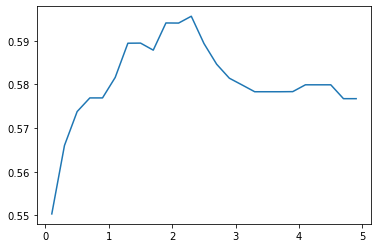

In [62]:
plt.plot(c_list1, mean_accuracy)

In [ ]:
# Vektoriseerimine ja TF-IDF rakendamine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe = Pipeline([('vect', CountVectorizer()),#tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Mudeli sobitamine
model = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print("Logistilise regressiooni mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

cm = confusion_matrix(y_test, prediction)

plot_confusion_matrix(cm, classes=['Tauniv', 'Õigeksmõistev'])